# Задание
1.	Сгенерировать набор данных на основе web-скрапинга (код в отдельном файле) для получения отзывов пользователей и их оценок с сайта Кинопоиск.
2.	Изучить набор данных, исследовать на пропуске, выбросы, балансировку по классам и тд
3.	Для решения задачи выбрать 3 модели. Минимум одна модель – классическое машинное обучение. Минимум одна модель – глубокий/нейросетевой подход.
4.	Выбрать функцию потерь.
5.	Выбрать критерии качества решения задачи.
6.	Произвести тренировку моделей. Выбрать наилучший.

# Решение

1. Чтение датасета

In [1]:
import pandas as pd

def get_df(path = 'reviews_with_sentiments.csv'):
    return pd.read_csv(path)

2. Изучение датасета

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_info(df):
    print(f'Общая информация о наборе данных\n{df.info()}\n')
    print(f'\nПроверка пропусков в данных\n{df.isnull().sum()}\n')

    print(f'\nПроверка на выбросы в оценке\n{df['Sentiment'].describe()}')
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Sentiment'])
    plt.title('Выбросы в оценке')
    plt.show()

    print('Балансировка по классу оценки')
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Sentiment'], bins=20, kde=True, color='blue')
    plt.title('Распределение оценок Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Частота')
    plt.show()

    print('Анализ длины отзывов')
    df['Review_Length'] = df['Review'].astype(str).apply(len)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Review_Length'], bins=50, kde=True, color='green')
    plt.title('Распределение длины отзывов')
    plt.xlabel('Длина отзыва')
    plt.ylabel('Частота')
    plt.show()

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    
    morph = MorphAnalyzer()
    stop_words = set(stopwords.words('russian'))
    
    text = re.sub(r'[^а-яё\s]', '', text.lower(), flags=re.UNICODE)

    tokens = word_tokenize(text, language='russian')

    processed_tokens = [
        morph.normal_forms(token)[0]
        for token in tokens
        if token not in stop_words and len(token) > 1
    ]

    return ' '.join(processed_tokens)

3. Выбор моделей

Модель №1 и №2. Классическое машинное обучение

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

def get_classic_model(X_train, y_train, model):

    nltk.download('stopwords')
    stop_words = stopwords.words('russian')
    
    if model == 'forest':
        classifer = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    else: # model = naive_bayes
        classifer = MultinomialNB()

    model = make_pipeline(
        TfidfVectorizer(
            stop_words=stop_words,        # Русские стоп-слова
            max_features=5000,            # Ограничение количества признаков
            ngram_range=(1, 2),           # Учитываем униграммы и биграммы
            min_df=5,                     # Убираем слишком редкие слова
            max_df=0.8                    # Убираем слишком частые слова
        ),
        classifer
    )

    model.fit(X_train, y_train)
    return model

Модель №3. Нейросетевой подход

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D

def split_df_model3(df):
    df['Sentiment'] = df['Sentiment'] + 1
    X, y = df['Review'], df['Sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Параметры токенизации
    vocab_size = 10000  # Максимальный размер словаря
    max_length = 100    # Максимальная длина последовательности
    oov_token = "<OOV>"  # Токен для неизвестных слов

    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

    return X_train_padded, X_test_padded, y_train, y_test


def get_neural_model(X_train, X_test, y_train, y_test):
    vocab_size = 10000  # Размер словаря
    embedding_dim = 64  # Размер векторного представления слов
    max_length = 100    # Максимальная длина отзывов

    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

    return model

In [6]:
def get_predict(model, X_test):
    return model.predict(X_test).argmax(axis=1)

4 и 5. Получение метрик

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

def get_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f'Функции потерь:\nMSE: {mse}\nMAE: {mae}\nRMSE: {rmse}')

    r2 = r2_score(y_test, y_pred)
    print(f'Критерий качества решения\nR2: {r2}')

## Показ результатов решения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18036 entries, 0 to 18035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Film       18036 non-null  object
 1   Review     18036 non-null  object
 2   Sentiment  18036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 422.8+ KB
Общая информация о наборе данных
None


Проверка пропусков в данных
Film         0
Review       0
Sentiment    0
dtype: int64


Проверка на выбросы в оценке
count    18036.000000
mean         0.733755
std          0.598468
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Sentiment, dtype: float64


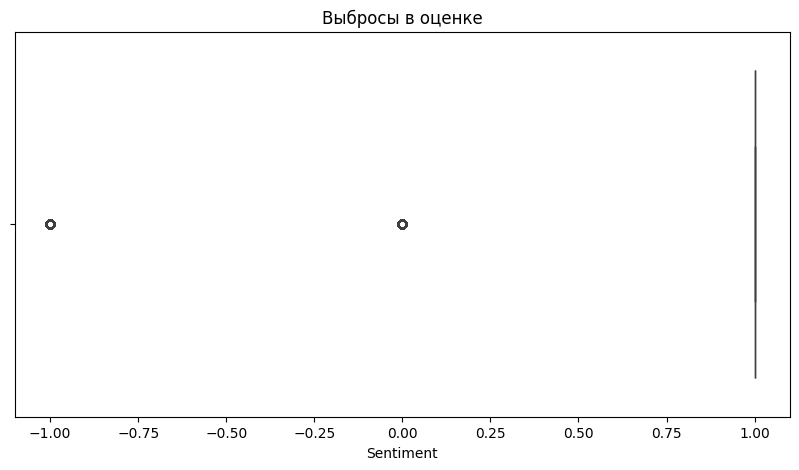

Балансировка по классу оценки


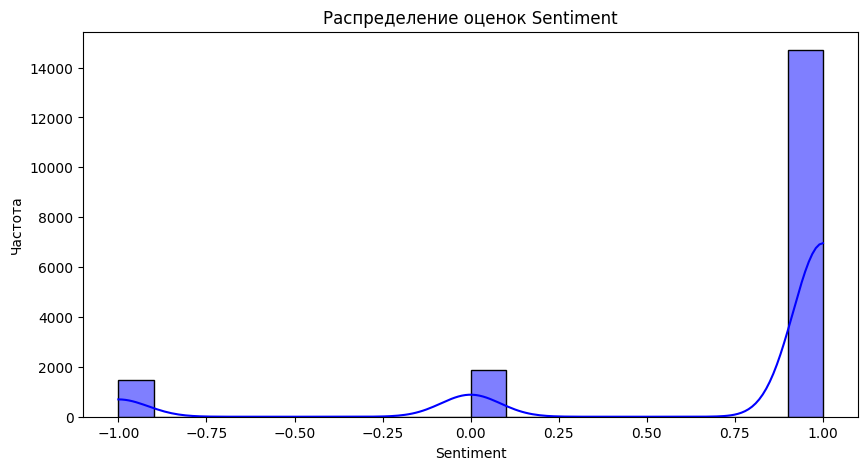

Анализ длины отзывов


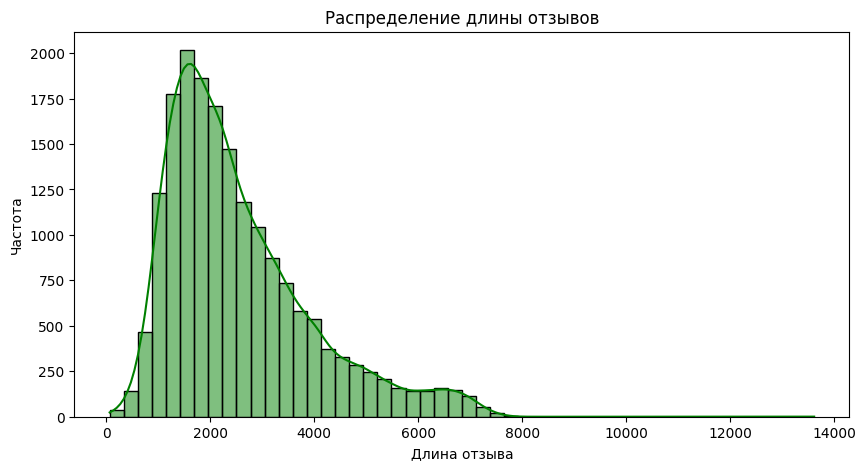

In [8]:
df = get_df()
get_info(df)

На основе изучения датасета, наша команда приняла решение сбалансировать его, убрав лишние строки с оценкой = 1

<class 'pandas.core.frame.DataFrame'>
Index: 5334 entries, 8 to 8769
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Film           5334 non-null   object
 1   Review         5334 non-null   object
 2   Sentiment      5334 non-null   int64 
 3   Review_Length  5334 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 208.4+ KB
Общая информация о наборе данных
None


Проверка пропусков в данных
Film             0
Review           0
Sentiment        0
Review_Length    0
dtype: int64


Проверка на выбросы в оценке
count    5334.000000
mean        0.099738
std         0.800213
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Sentiment, dtype: float64


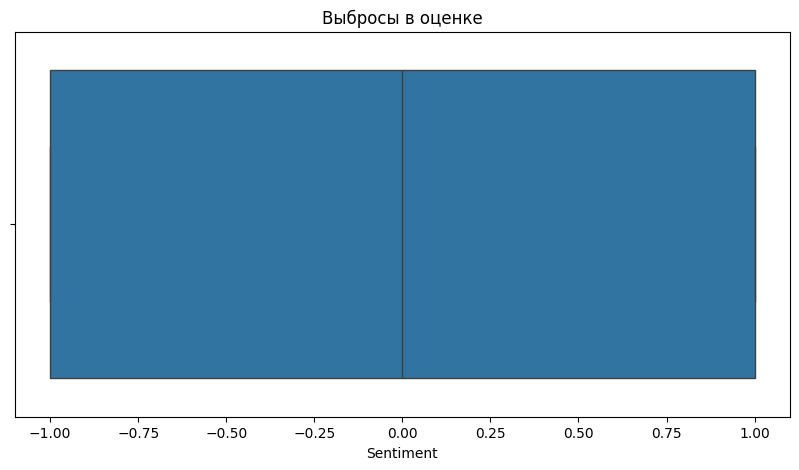

Балансировка по классу оценки


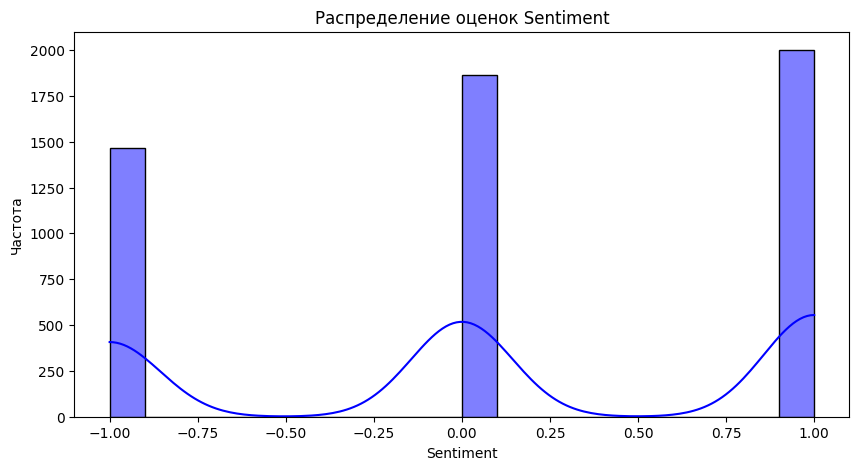

Анализ длины отзывов


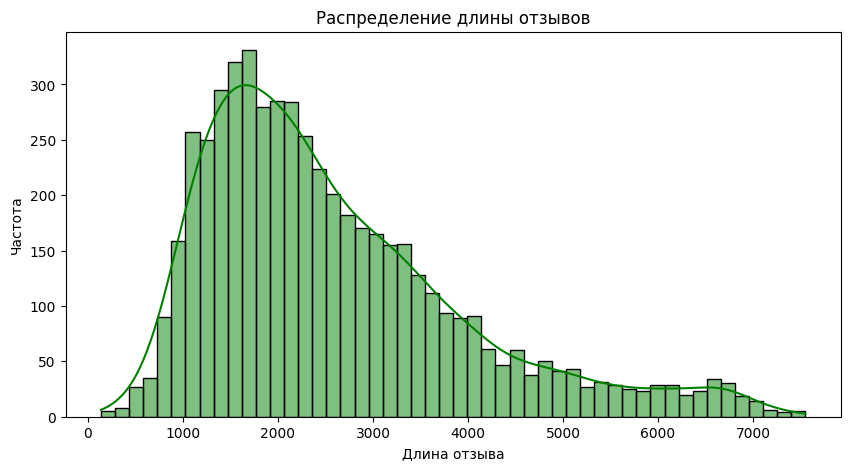

In [9]:
sentiment_1_rows = df[df['Sentiment'] == 1].sample(n=2000, random_state=42)
other_rows = df[df['Sentiment'] != 1]
df = pd.concat([other_rows, sentiment_1_rows])
get_info(df)

Получение данных

In [10]:
# df['Review'] = df['Review'].apply(preprocess_text)

X, y = df['Review'], df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Модель №1. RandomForestRegressor

In [11]:
model = get_classic_model(X_train, y_train, model='forest')
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Юлия\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функции потерь:
MSE: 0.4536799906279288
MAE: 0.5444704779756325
RMSE: 0.6735577114308238
Критерий качества решения
R2: 0.28134784220558784


Модель №2. MultinomialNB

In [12]:
model = get_classic_model(X_train, y_train, model='naive_bayes')
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Юлия\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функции потерь:
MSE: 0.4751640112464855
MAE: 0.4076850984067479
RMSE: 0.6893214135992625
Критерий качества решения
R2: 0.24731606188780064


Модель №3. Conv1D

In [13]:
X_train, X_test, y_train, y_test = split_df_model3(df)
model = get_neural_model(X_train, X_test, y_train, y_test)

Epoch 1/15


C:\Users\Юлия\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4061 - loss: 1.0513 - val_accuracy: 0.5979 - val_loss: 0.8266
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6716 - loss: 0.7048 - val_accuracy: 0.6317 - val_loss: 0.7664
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8370 - loss: 0.5512 - val_accuracy: 0.6448 - val_loss: 0.7609
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9291 - loss: 0.3392 - val_accuracy: 0.6354 - val_loss: 0.8153
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9777 - loss: 0.1413 - val_accuracy: 0.6382 - val_loss: 0.8796
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9967 - loss: 0.0524 - val_accuracy: 0.6336 - val_loss: 0.9645
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 0.6289 - val_loss: 1.0405
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.630

In [14]:
y_pred = get_predict(model, X_test)
get_metrics(y_test, y_pred)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Функции потерь:
MSE: 0.49109653233364575
MAE: 0.41424554826616683
RMSE: 0.7007827996844997
Критерий качества решения
R2: 0.22207813891362416
